Author - Priyanka Vasanthakumari

# PPO-NES


PPO-NES combines the advantages of both Proximal Policy Optimization (PPO) (Schulman et. al, 2017) and Neural Evolutionary Strategis (NES) (Salimans et. al, 2017). In PPO, the exploration is carried out in the action space by sampling from the categorical distribution as well as by the addition of an entropy term in the loss function. On the other hand, NES perturbs the neural network parameter space to facilitate exploration. Therefore, combining PPO and NES could potentially double the exploration, and eventually leads to better performance. PPO implemented in Asynchronous Actor Critic (A2C) style requires several workers (instances of actor network) to collect trajectories. In contrast, NES technique does not involve any trajectory collection or gradient descent steps. It simply works by perturbing the weights and updating the weights according to the roll-out evaluation rewards. 


The concept of transfer learning is utilized in PPO-NES, where the weights of a pre-trained network are used to initialize a model. Therefore, in comparison to initializing the model randomly, transfer learning enables the network to train on the shoulder of giant. The neural network in the NES algorithm and the actor network in the PPO algorithm has the same architecture. The critic network architecture does not depend on the NES network.   


The steps for the PPO-NES algorithm are:
1. Initialize the weights of the NES neural network
2. Run NES algorithm in the environment and train the network until evaluation reward >= (Target reward/2)
3. Transfer the trained weights of the NES network to initialize the PPO-actor network 4. Run the PPO algorithm until convergence. i.e., evaluation reward >= Target reward


This code is organized in the following way:

1) Implement PPO with clipped surrogate objective. The implementation also uses generalized advantage estimate (GAE) and entropy.


2) Implement NES. 


3) Implement PPO-NES. 


4) Comparison of results.  


In [ ]:
!apt-get update
!apt-get install xvfb
!apt-get install x11-utils
!apt-get install ffmpeg
!apt-get install python-opengl 
!pip -q install gym pyvirtualdisplay pygame
!pip3 install box2d-py


Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [53.9 kB]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:13 http://security.ubuntu.com/ubuntu bion

In [ ]:
"""ENVIRONMENT"""
import gym                                                                      #OpenAI gym 
gym.logger.set_level(40)                                                        #suppresses warning messages, displays only error messages

"""MODELS AND TOOLS FOR OPTIMIZATION AND OTHER COMPUTATIONS"""
import time
import numpy as np
import torch                                                                    #will use PyTorch to handle the NN 
import torch.nn as nn                                                           #contains various NN layers
import torch.distributions as pdf                                               #contains various distributions such as Normal and Categorical
import torch.nn.functional as F                                                 #includes various functions such as convolution etc.
import torch.optim as optim                                                     #contains various optimization algorithms
import random
from random import sample
from collections import deque, namedtuple
from torch.distributions import Categorical

"""VISUALIZATION"""
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image
#from numpngw import write_apng
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import Monitor
import base64
import copy


"""I/O"""
import os
from pathlib import Path

In [ ]:
from google.colab import drive
from google.colab import files

def save_checkpoint(model, filename, mode=0):
    """
    Save a model to a file in your colab space 
        
    Parameters
    ----------
    model: your policy network
    filename: the name of the checkpoint file
    mode (int): determines where to store the file
                --> 0: collab space 1: Google Drive
    """
    if mode == 1: 
      drive.mount('/content/gdrive')
      path = F"/content/gdrive/My Drive/{filename}" 
      torch.save(model.state_dict(), path)
    else:
      torch.save(model.state_dict(), filename)

def export_to_local_drive(filename):
    """
    Download a file to your local machine 
        
    Parameters
    ----------
    filename: the name of the file
    """
    files.download(filename)


In [ ]:
'''DISPLAY'''
display=Display(visible=0, size=(600, 400))
display.start()

#Define a simple helper function to visualize the episodes
def show_video(path):
    html = []
    for mp4 in Path(path).glob("*.mp4"):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append('''<video alt="{}" autoplay 
                      controls style="height: 400px;">
                      <source src="data:video/mp4;base64,{}" type="video/mp4" />
                 </video>'''.format(mp4, video_b64.decode('ascii')))
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

In [ ]:
'''ENVIRONMENT TESTING'''
env = gym.make("CartPole-v0")
env.seed(0)
env = Monitor(env, './video', force=True, video_callable=lambda episode: True)
env.reset()
done = False
while not done:
    action = 1
    obs, reward, done, info = env.step(action)
env.close()
show_video('./video')

In [ ]:
print('observation space:',env.observation_space)
print('action space:',env.action_space)
print('solved_score',env.spec.reward_threshold)

env = gym.make('CartPole-v0')                                              
reward_goal = env.spec.reward_threshold                                       
observations = env.observation_space.shape[0]                                     
actions = env.action_space.n      

observation space: Box(-inf, inf, (8,), float32)
action space: Discrete(4)
solved_score 200


# PPO with clipped objective and GAE

#iterations: 0 	#trajectories: 224 	Evaluation reward: 36.00 	Mean Evaluation reward: 36.00
#iterations: 1 	#trajectories: 155 	Evaluation reward: 108.00 	Mean Evaluation reward: 72.00
#iterations: 2 	#trajectories: 111 	Evaluation reward: 200.00 	Mean Evaluation reward: 114.67
#iterations: 3 	#trajectories: 65 	Evaluation reward: 200.00 	Mean Evaluation reward: 136.00
#iterations: 4 	#trajectories: 47 	Evaluation reward: 200.00 	Mean Evaluation reward: 148.80
#iterations: 5 	#trajectories: 41 	Evaluation reward: 200.00 	Mean Evaluation reward: 157.33
#iterations: 6 	#trajectories: 40 	Evaluation reward: 200.00 	Mean Evaluation reward: 163.43
#iterations: 7 	#trajectories: 30 	Evaluation reward: 197.00 	Mean Evaluation reward: 167.62
#iterations: 8 	#trajectories: 33 	Evaluation reward: 137.00 	Mean Evaluation reward: 164.22
#iterations: 9 	#trajectories: 36 	Evaluation reward: 200.00 	Mean Evaluation reward: 167.80
#iterations: 10 	#trajectories: 30 	Evaluation reward: 200.00 	Mean Ev

Text(0.5, 0, 'Iterations')

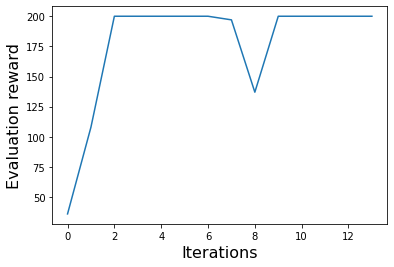

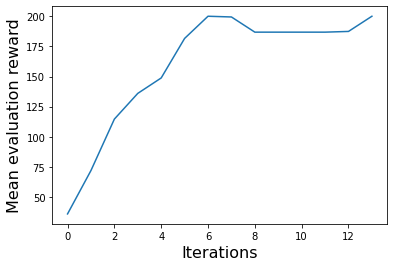

In [ ]:
''' Proximal Policy Optimization '''

device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
'''POLICY NETWORK(ACTOR)'''
class Policy(nn.Module):                                                        
  def __init__(self,observations,actions,hidden_unit1,hidden_unit2):                          
    super(Policy,self).__init__()
    self.l1 = nn.Linear(observations,hidden_unit1)                                        
    self.l2 = nn.Linear(hidden_unit1,hidden_unit2)                                                  
    self.l3 = nn.Linear(hidden_unit2,actions)  
    self.out = nn.Softmax(dim=-1)                                            

  def forward(self,x):                                                          #forward propagation function
    if not isinstance(x,torch.Tensor):                                          
      x = torch.tensor(x,device=device,dtype=torch.float32)                       
      x = x.unsqueeze(0)
    x = torch.tanh(self.l1(x))                                                    
    x = torch.tanh(self.l2(x))
    x = torch.tanh(self.l3(x))
    x = self.out(x)
    return x    

  def action_dist(self, x):
    action_probs = self.forward(x)   
    dist = Categorical(action_probs)  
    return dist

  def greedy_action(self, x):
    return self.forward(x) 

''' VALUE (CRITIC) NETWORK '''
class Value(nn.Module):
  def __init__(self,observations,hidden_unit1,hidden_unit2):                                 
    super(Value,self).__init__()
    self.l1 = nn.Linear(observations,hidden_unit1)                                         
    self.l2 = nn.Linear(hidden_unit1,1)                                                    

  def forward(self,x):                                                          #forward propagation function
    if not isinstance(x,torch.Tensor):                                          
      x = torch.tensor(x,device=device,dtype=torch.float32)                      
      x = x.unsqueeze(0)
    x = F.relu(self.l1(x))                                                        
    x = self.l2(x)
    return x  

'''PPO AGENT'''
class PPOagent():
  def __init__(self,observations,actions,hP1,hP2,hV1,hV2,lr_P,
               lr_V, buffer_size):
    self.policynet = Policy(observations,actions,hP1,hP2).to(device)        #policy-network
    self.valuenet = Value(observations,hV1,hV2).to(device)                  #value-network
    self.policyOptimizer = optim.Adam(self.policynet.parameters(),lr=lr_P)      
    self.valueOptimizer = optim.Adam(self.valuenet.parameters(),lr=lr_V) 
    self.D=deque(maxlen=buffer_size)   
    self.trajectory = namedtuple("Trajectory", field_names=["state", "action", "reward", "next_state", "log_prob", "Advantage", "yt"])     

  def learn (self, env, seed, gamma, epsilon, lamda, max_iter,H, mini_batch_size, epochs, reward_goal, entropy_weight):
    eval_rewards = []
    eval_rewards_mean = []
    eval_reward10 = deque(maxlen=5)
    for iter in range(max_iter):
      self.D.clear()
      num_traj = self.collect_trajectory(env,H,gamma,lamda)                                #Collects trajectories and saves into buffer
      self.ppo_learn(epsilon, mini_batch_size, epochs, entropy_weight)
      self.valueNet_update(mini_batch_size, epochs)
      eval_reward=self.evaluation(env) 
      eval_rewards.append(eval_reward)
      eval_reward10.append(eval_reward)
      eval_rewards_mean.append(np.mean(eval_reward10))
      print('\r#iterations: {:d} \t#trajectories: {:d} \tEvaluation reward: {:.2f} \tMean Evaluation reward: {:.2f}'.format(iter,num_traj,eval_reward, np.mean(eval_rewards)))
      if iter>=10 and np.mean(eval_reward10) >= reward_goal: break
    return self.policynet,self.valuenet, eval_rewards, eval_rewards_mean

  def collect_trajectory(self, env, H, gamma, lamda):                                   #Collect trajectories to fill the buffer using workers
    seeds = random.sample(range(0, 1000), 1000)
    num_traj = 0
    while True:
      env.seed(seeds.pop()) 
      traj,states = [],[]
      s = env.reset()
      terminal = False
      while not terminal:
        s = torch.tensor(s).type(torch.FloatTensor).to(device)
        dist = self.policynet.action_dist(s)
        action = dist.sample() 
        action_logprob = dist.log_prob(action).cpu().detach().data.numpy().squeeze()
        action = action.cpu().detach().data.numpy().squeeze()
        next_state,r,terminal,_ = env.step(int(action))
        s = s.cpu().detach().data.numpy().squeeze()
        traj.append((s,action,r,next_state,len(traj)+1,action_logprob))
        states.append(s)
        s = next_state
        if len(traj)==H:
          break
      num_traj +=1
      states = torch.from_numpy(np.array(states)).float().to(device)
      values = self.valuenet(states).cpu().detach().data.numpy()
      self.gae(traj,values,gamma,lamda)
      if len(self.D)>=self.D.maxlen: break
    return num_traj


  def gae(self,traj,values,gamma,lamda):
    temp=[]                                                                     #saves the new version of 'trajectory'. The new version will have information about GAE and 'yt'
    for experience,index in zip(traj,range(len(traj))):             #loop over all experiences in the trajectory
      advantages=[]                                                             #stores the n-step advantage estimates of 'experience' as n=1,2,...end of the episode
      temp1=experience[2]-float(values[index])                                  #first and last terms of all n-step advantage estimates are the same and equal to (r(st,at)-Vhatφπ(st))
      #comment out the following line to use a TD(λ) target
      yt=experience[2]
      for n in range(1,len(traj)-experience[4]+1):                        #loops over the trajectory between the point of occurence of 'experience' and the end of the trajectory
        #comment out the following line to use a TD(λ) target
        yt+=((gamma**n)*traj[index+n][2])                                 #accumulating discounted MC rewards for the value-function target 'yt'
        if n==1:                                                                #calculate the 1-step advantage estimate
          advantages.append(temp1+(gamma*float(values[index+1])))
        else:                                                                   #start computing the n-step advantage estimate where 'n' is at least 2
          temp2=0                                                               #saves the sum of all individual terms in the n-step estimate
          for j in range(1,n+1):                                                #loop facilitates computation of the values of the individual terms in the n-step estimate
            if j!=n:temp2+=((gamma**j)*traj[index+j][2])                  #if this condition is satisfied, we consider only the reward terms             
            else:temp2+=((gamma**n)*float(values[index+n]))                     #if j=n, we compute the value of the penultimate term in the n-step estimate, which is Vhatφπ(st+n)
          advantages.append(temp1+temp2)                                        #add the last computed estimate to 'advantages'
      weights=[(1-lamda)*(lamda**k) for k in range(len(advantages))]            #weights of each n-step estimate is (1-λ)(λ^(n-1))
      weightedAdvantages=[weight*advantage for weight,
                          advantage in zip(weights,advantages)]                 #weighted sum of all advantage estimates
      #comment out the following line to use a TD(λ) target
      self.D.append(self.trajectory(experience[0],experience[1],experience[2],experience[3],
                   experience[5],sum(weightedAdvantages),yt))                   #yt here is an MC target
      #uncomment the following line to use a TD(λ) target
      #temp.append((experience[0],experience[1],experience[2],experience[3],experience[5],sum(weightedAdvantages),sum(weightedAdvantages)+value))#yt here is a TD(λ) target
    

  def ppo_learn(self, epsilon, mini_batch_size, epochs, entropy_weight):
    for epoch in range(epochs):
      exp_mini_batch = random.sample(self.D, k = mini_batch_size)
      states = torch.from_numpy(np.vstack([i.state for i in exp_mini_batch if i is not None])).float().to(device)
      actions = torch.from_numpy(np.vstack([i.action for i in exp_mini_batch if i is not None])).long().to(device)
      rewards = torch.from_numpy(np.vstack([i.reward for i in exp_mini_batch if i is not None])).float().to(device)
      next_states = torch.from_numpy(np.vstack([i.next_state for i in exp_mini_batch if i is not None])).float().to(device)
      log_probs = torch.from_numpy(np.vstack([i.log_prob for i in exp_mini_batch if i is not None])).float().to(device)
      advantages = torch.from_numpy(np.vstack([i.Advantage for i in exp_mini_batch if i is not None])).float().to(device)
      yts = torch.from_numpy(np.vstack([i.yt for i in exp_mini_batch if i is not None])).float().to(device)

      dist_new = self.policynet.action_dist(states)
      action_logprob_new = dist_new.log_prob(actions.T)
      ratio = (torch.flatten(action_logprob_new)-torch.flatten(log_probs)).exp() #Numerically more stable
      Obj_fn = torch.min(ratio*torch.flatten(advantages),torch.clamp(ratio,1-epsilon,1+epsilon)*torch.flatten(advantages)).mean() 
      entropy=dist_new.entropy().mean() 
      ppo_loss = -Obj_fn - entropy*entropy_weight
      self.policyOptimizer.zero_grad()                                          #set all gradients to zero before gradient descent
      ppo_loss.backward()                                                     #perform backpropagation to compute the gradients
      self.policyOptimizer.step() 
      
  def valueNet_update(self,mini_batch_size, epochs):
    for epoch in range(epochs):
      exp_mini_batch = random.sample(self.D, k = mini_batch_size)
      states = torch.from_numpy(np.vstack([i.state for i in exp_mini_batch if i is not None])).float().to(device)
      actions = torch.from_numpy(np.vstack([i.action for i in exp_mini_batch if i is not None])).long().to(device)
      rewards = torch.from_numpy(np.vstack([i.reward for i in exp_mini_batch if i is not None])).float().to(device)
      next_states = torch.from_numpy(np.vstack([i.next_state for i in exp_mini_batch if i is not None])).float().to(device)
      log_probs = torch.from_numpy(np.vstack([i.log_prob for i in exp_mini_batch if i is not None])).float().to(device)
      advantages = torch.from_numpy(np.vstack([i.Advantage for i in exp_mini_batch if i is not None])).float().to(device)
      yts = torch.from_numpy(np.vstack([i.yt for i in exp_mini_batch if i is not None])).float().to(device)
      values=self.valuenet(states)
      value_loss=((torch.flatten(yts)-torch.flatten(values))**2).mean()
      self.valueOptimizer.zero_grad()
      value_loss.backward()
      self.valueOptimizer.step() 

  def evaluation(self,env):
    s = env.reset()
    terminal = False
    rewards = []
    rewards.append(0)
    while not terminal:
      s = torch.tensor(s).type(torch.FloatTensor).to(device)
      dis = self.policynet.greedy_action(s)
      action = np.argmax(dis.cpu().data.numpy())
      next_state,r,terminal,_=env.step(action)
      rewards[-1]+=r
      s = next_state
    return (np.mean(rewards))

#env = gym.make('LunarLander-v2')                                              
reward_goal = env.spec.reward_threshold                                       
observations = env.observation_space.shape[0]                                     
actions = env.action_space.n                                               
H = 1000                                               
hP1,hP2 = 100,100                                                      
hV1,hV2 = 64,64                                                       
max_iter = 100                                                               
buffer_size = 5000                                                                     
lr_P = 5e-4                                                                     
lr_V = 1e-2                                                                     
seed = 0                                                                          
gamma = 0.99                                                                      
lamda = 0.96                                                                      
mini_batch_size = 500                                                                        
epochs = 20                                                                       
epsilon = 2e-1                                                                    
entropy_weight=5e-3                                                              



"""PPO"""
agent = PPOagent(observations,actions,hP1,hP2,hV1,hV2,lr_P,lr_V, buffer_size)
policyModel,valueModel, eval_rewards_PPO, eval_rewards_mean_PPO = agent.learn(env, seed, gamma, epsilon, lamda, max_iter,H, mini_batch_size, epochs, reward_goal, entropy_weight)


plt.figure(0)
plt.plot(eval_rewards_PPO)
plt.ylabel("Evaluation reward",fontsize=16)
plt.xlabel("Iterations",fontsize=16)

plt.figure(1)
plt.plot(eval_rewards_mean_PPO)
plt.ylabel("Mean evaluation reward",fontsize=16)
plt.xlabel("Iterations",fontsize=16)
   


# NEURAL EVOLUTION STRATEGIES

[10.0]
[10.0]
[12.0]
[9.0]
[68.0]
[24.0]
[27.0]
[25.0]
[10.0]
[17.0]
[21.0]
[10.0]
[29.0]
[76.0]
[18.0]
[12.0]
[112.0]
[29.0]
[34.0]
[24.0]
[14.0]
[14.0]
[177.0]
[11.0]
[192.0]
[200.0]
[115.0]
[200.0]


Text(0.5, 0, 'Iterations')

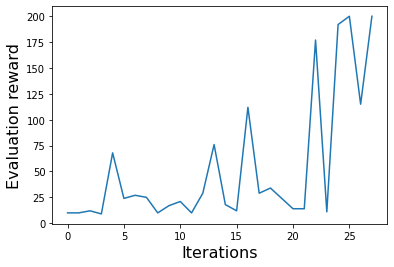

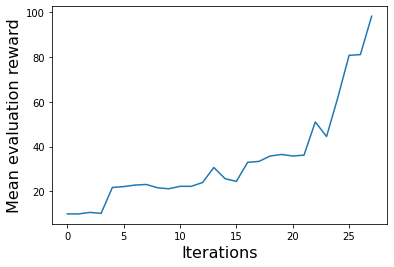

In [ ]:
''' Neural Evolution Strategies '''
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class Network(nn.Module):                                                        
  def __init__(self,observations,actions,hidden_unit1,hidden_unit2):                          
    super(Network,self).__init__()
    self.l1 = nn.Linear(observations,hidden_unit1)                                        
    self.l2 = nn.Linear(hidden_unit1,hidden_unit2)                                                  
    self.l3 = nn.Linear(hidden_unit2,actions)  
    self.out = nn.Softmax(dim=-1)                                            

  def forward(self,x):                                                          #forward propagation function
    if not isinstance(x,torch.Tensor):                                          
      x = torch.tensor(x,device=device,dtype=torch.float32)                       
      x = x.unsqueeze(0)
    x = torch.tanh(self.l1(x))                                                    
    x = torch.tanh(self.l2(x))
    x = torch.tanh(self.l3(x))
    x = self.out(x)
    return x    

class NES_agent():
  def __init__(self,observations,actions,hP1,hP2):
    self.net = Network(observations,actions,hP1,hP2).to(device) 
    self.copy_net = Network(observations,actions,hP1,hP2).to(device) 

  def ES_train(self, env, lr, sigma, gamma, max_iter, seed, n_epsilon, reward_goal):
    self.sigma = sigma
    eval_rewards = []
    eval_reward10 = deque(maxlen=10) 
    eval_reward_mean = []
    for i in range(max_iter):
      epsilons, new_thetas = self.perturbations(sigma, n_epsilon)
      returns = self.get_return(new_thetas, gamma)
      new_weight = self.update_theta (returns, epsilons, sigma, n_epsilon, lr)
      eval_reward = self.evaluation(env) 
      eval_reward10.append(eval_reward)
      eval_rewards.append(eval_reward)
      eval_reward_mean.append(np.mean(eval_reward10))
      print(eval_reward)
      #print('\r#iterations: {:d} \tEvaluation reward: {:.2f} \tMean Evaluation reward: {:.2f}'.format(i,eval_reward, np.mean(eval_rewards)))
      if np.mean(eval_reward10) >= reward_goal/2: break
    return self.net, eval_rewards, eval_reward_mean


  def perturbations(self, sigma, n_epsilon):
    params = self.net.state_dict()
    epsilons = []
    new_thetas = []
    for i in range(n_epsilon):
      params_copy = copy.deepcopy(params)
      epsilon = copy.deepcopy(params)
      for param_tensor in params_copy:
        epsilon[param_tensor] = torch.randn(epsilon[param_tensor].shape)
        params_copy[param_tensor] += sigma * epsilon[param_tensor].to(device)
      epsilons.append(epsilon)
      new_thetas.append(params_copy)
    return epsilons, new_thetas

  def get_return (self, new_thetas, gamma):
    returns = []
    for i in range (len(new_thetas)):
      theta = new_thetas[i]
      self.copy_net.load_state_dict(theta)
      s = env.reset()
      terminal = False
      returns.append(0.0)
      count = 0
      while not terminal:
        s = torch.tensor(s).type(torch.FloatTensor).to(device)
        Q = self.copy_net(s).cpu().detach().data.numpy().squeeze()
        action = np.argmax(Q)
        s, r, terminal,_ = env.step(action)
        returns[-1] += pow(gamma, count) * r
        count += 1
    return returns

  def update_theta (self,returns, epsilons, sigma, n_epsilon, lr):
    returns = torch.Tensor(returns).to(device)
    params = self.net.state_dict()
    params_copy = copy.deepcopy(params)
    for param_tensor in params_copy:
      sum_t = torch.zeros((epsilons[0][param_tensor].shape)).to(device)
      for i in range(len(returns)):
        sum_t += returns[i] * epsilons[i][param_tensor].to(device)
      params_copy[param_tensor] += (lr/(n_epsilon * sigma)) * sum_t
    self.net.load_state_dict(params_copy)

  def evaluation(self,env):
    returns = []
    s = env.reset()
    terminal = False
    returns.append(0)
    count = 0
    while not terminal:
      s = torch.tensor(s).type(torch.FloatTensor).to(device)
      Q = self.copy_net(s).cpu().detach().data.numpy().squeeze()
      action = np.argmax(Q)
      s, r, terminal,_ = env.step(action)
      returns[-1] += r
      count += 1
    return returns


                                              
H = 1000                                               
hP1,hP2 = 100,100                                                      
max_iter = 500                                                               
lr = 0.00025                                                                     
seed = 0                                                                          
gamma = 0.999    
sigma = 0.1 
n_epsilon = 100                                                                 



"""NES"""
agent = NES_agent(observations,actions,hP1,hP2)
Model, eval_rewards_NES, eval_rewards_mean_NES = agent.ES_train(env, lr, sigma, gamma, max_iter, seed, n_epsilon, reward_goal)

plt.figure(0)
plt.plot(eval_rewards_NES)
plt.ylabel("Evaluation reward",fontsize=16)
plt.xlabel("Iterations",fontsize=16)

plt.figure(1)
plt.plot(eval_rewards_mean_NES)
plt.ylabel("Mean evaluation reward",fontsize=16)
plt.xlabel("Iterations",fontsize=16)
   



# PPO - NES 

#iterations: 0 	#trajectories: 50 	Evaluation reward: 192.00 	Mean Evaluation reward: 192.00
#iterations: 1 	#trajectories: 41 	Evaluation reward: 200.00 	Mean Evaluation reward: 196.00
#iterations: 2 	#trajectories: 35 	Evaluation reward: 200.00 	Mean Evaluation reward: 197.33
#iterations: 3 	#trajectories: 37 	Evaluation reward: 191.00 	Mean Evaluation reward: 195.75
#iterations: 4 	#trajectories: 34 	Evaluation reward: 200.00 	Mean Evaluation reward: 196.60
#iterations: 5 	#trajectories: 43 	Evaluation reward: 168.00 	Mean Evaluation reward: 191.83
#iterations: 6 	#trajectories: 45 	Evaluation reward: 200.00 	Mean Evaluation reward: 193.00
#iterations: 7 	#trajectories: 37 	Evaluation reward: 200.00 	Mean Evaluation reward: 193.88
#iterations: 8 	#trajectories: 32 	Evaluation reward: 200.00 	Mean Evaluation reward: 194.56
#iterations: 9 	#trajectories: 30 	Evaluation reward: 200.00 	Mean Evaluation reward: 195.10
#iterations: 10 	#trajectories: 28 	Evaluation reward: 200.00 	Mean Ev

Text(0.5, 0, 'Iterations')

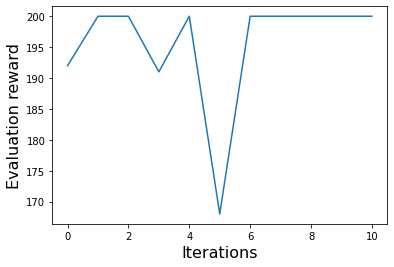

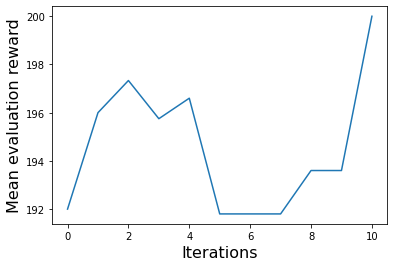

In [ ]:
''' Proximal Policy Optimization - NES '''

device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
'''POLICY NETWORK(ACTOR)'''
class Policy(nn.Module):                                                        
  def __init__(self,observations,actions,hidden_unit1,hidden_unit2):                          
    super(Policy,self).__init__()
    self.l1 = nn.Linear(observations,hidden_unit1)                                        
    self.l2 = nn.Linear(hidden_unit1,hidden_unit2)                                                  
    self.l3 = nn.Linear(hidden_unit2,actions)  
    self.out = nn.Softmax(dim=-1)                                            

  def forward(self,x):                                                          #forward propagation function
    if not isinstance(x,torch.Tensor):                                          
      x = torch.tensor(x,device=device,dtype=torch.float32)                       
      x = x.unsqueeze(0)
    x = torch.tanh(self.l1(x))                                                    
    x = torch.tanh(self.l2(x))
    x = torch.tanh(self.l3(x))
    x = self.out(x)
    return x    

  def action_dist(self, x):
    action_probs = self.forward(x)   
    dist = Categorical(action_probs)  
    return dist

  def greedy_action(self, x):
    return self.forward(x) 

''' VALUE (CRITIC) NETWORK '''
class Value(nn.Module):
  def __init__(self,observations,hidden_unit1,hidden_unit2):                                 
    super(Value,self).__init__()
    self.l1 = nn.Linear(observations,hidden_unit1)                                         
    self.l2 = nn.Linear(hidden_unit1,1)                                                    

  def forward(self,x):                                                          #forward propagation function
    if not isinstance(x,torch.Tensor):                                          
      x = torch.tensor(x,device=device,dtype=torch.float32)                      
      x = x.unsqueeze(0)
    x = F.relu(self.l1(x))                                                        
    x = self.l2(x)
    return x  

'''PPO AGENT'''
class PPOagent():
  def __init__(self,observations,actions,hP1,hP2,hV1,hV2,lr_P,
               lr_V, buffer_size):
    self.policynet = Policy(observations,actions,hP1,hP2).to(device)        #policy-network
    self.valuenet = Value(observations,hV1,hV2).to(device)                  #value-network
    self.policyOptimizer = optim.Adam(self.policynet.parameters(),lr=lr_P)      
    self.valueOptimizer = optim.Adam(self.valuenet.parameters(),lr=lr_V) 
    self.D=deque(maxlen=buffer_size)   
    self.trajectory = namedtuple("Trajectory", field_names=["state", "action", "reward", "next_state", "log_prob", "Advantage", "yt"])     

  def learn (self, env, seed, gamma, epsilon, lamda, max_iter,H, mini_batch_size, epochs, reward_goal, entropy_weight, NES_weights):
    self.policynet.load_state_dict(NES_weights)
    eval_rewards = []
    eval_rewards_mean = []
    eval_reward10 = deque(maxlen=5)
    for iter in range(max_iter):
      self.D.clear()
      num_traj = self.collect_trajectory(env,H,gamma,lamda)                                #Collects trajectories and saves into buffer
      self.ppo_learn(epsilon, mini_batch_size, epochs, entropy_weight)
      self.valueNet_update(mini_batch_size, epochs)
      eval_reward=self.evaluation(env) 
      eval_rewards.append(eval_reward)
      eval_reward10.append(eval_reward)
      eval_rewards_mean.append(np.mean(eval_reward10))
      print('\r#iterations: {:d} \t#trajectories: {:d} \tEvaluation reward: {:.2f} \tMean Evaluation reward: {:.2f}'.format(iter,num_traj,eval_reward, np.mean(eval_rewards)))
      if iter>=5 and np.mean(eval_reward10) >= reward_goal: break
    return self.policynet,self.valuenet, eval_rewards, eval_rewards_mean

  def collect_trajectory(self, env, H, gamma, lamda):                                   #Collect trajectories to fill the buffer using workers
    seeds = random.sample(range(0, 1000), 1000)
    num_traj = 0
    while True:
      env.seed(seeds.pop()) 
      traj,states = [],[]
      s = env.reset()
      terminal = False
      while not terminal:
        s = torch.tensor(s).type(torch.FloatTensor).to(device)
        dist = self.policynet.action_dist(s)
        action = dist.sample() 
        action_logprob = dist.log_prob(action).cpu().detach().data.numpy().squeeze()
        action = action.cpu().detach().data.numpy().squeeze()
        next_state,r,terminal,_ = env.step(int(action))
        s = s.cpu().detach().data.numpy().squeeze()
        traj.append((s,action,r,next_state,len(traj)+1,action_logprob))
        states.append(s)
        s = next_state
        if len(traj)==H:
          break
      num_traj +=1
      states = torch.from_numpy(np.array(states)).float().to(device)
      values = self.valuenet(states).cpu().detach().data.numpy()
      self.gae(traj,values,gamma,lamda)
      if len(self.D)>=self.D.maxlen: break
    return num_traj


  def gae(self,traj,values,gamma,lamda):
    temp=[]                                                                     #saves the new version of 'trajectory'. The new version will have information about GAE and 'yt'
    for experience,index in zip(traj,range(len(traj))):             #loop over all experiences in the trajectory
      advantages=[]                                                             #stores the n-step advantage estimates of 'experience' as n=1,2,...end of the episode
      temp1=experience[2]-float(values[index])                                  #first and last terms of all n-step advantage estimates are the same and equal to (r(st,at)-Vhatφπ(st))
      #comment out the following line to use a TD(λ) target
      yt=experience[2]
      for n in range(1,len(traj)-experience[4]+1):                        #loops over the trajectory between the point of occurence of 'experience' and the end of the trajectory
        #comment out the following line to use a TD(λ) target
        yt+=((gamma**n)*traj[index+n][2])                                 #accumulating discounted MC rewards for the value-function target 'yt'
        if n==1:                                                                #calculate the 1-step advantage estimate
          advantages.append(temp1+(gamma*float(values[index+1])))
        else:                                                                   #start computing the n-step advantage estimate where 'n' is at least 2
          temp2=0                                                               #saves the sum of all individual terms in the n-step estimate
          for j in range(1,n+1):                                                #loop facilitates computation of the values of the individual terms in the n-step estimate
            if j!=n:temp2+=((gamma**j)*traj[index+j][2])                  #if this condition is satisfied, we consider only the reward terms             
            else:temp2+=((gamma**n)*float(values[index+n]))                     #if j=n, we compute the value of the penultimate term in the n-step estimate, which is Vhatφπ(st+n)
          advantages.append(temp1+temp2)                                        #add the last computed estimate to 'advantages'
      weights=[(1-lamda)*(lamda**k) for k in range(len(advantages))]            #weights of each n-step estimate is (1-λ)(λ^(n-1))
      weightedAdvantages=[weight*advantage for weight,
                          advantage in zip(weights,advantages)]                 #weighted sum of all advantage estimates
      #comment out the following line to use a TD(λ) target
      self.D.append(self.trajectory(experience[0],experience[1],experience[2],experience[3],
                   experience[5],sum(weightedAdvantages),yt))                   #yt here is an MC target
      #uncomment the following line to use a TD(λ) target
      #temp.append((experience[0],experience[1],experience[2],experience[3],experience[5],sum(weightedAdvantages),sum(weightedAdvantages)+value))#yt here is a TD(λ) target
    

  def ppo_learn(self, epsilon, mini_batch_size, epochs, entropy_weight):
    for epoch in range(epochs):
      exp_mini_batch = random.sample(self.D, k = mini_batch_size)
      states = torch.from_numpy(np.vstack([i.state for i in exp_mini_batch if i is not None])).float().to(device)
      actions = torch.from_numpy(np.vstack([i.action for i in exp_mini_batch if i is not None])).long().to(device)
      rewards = torch.from_numpy(np.vstack([i.reward for i in exp_mini_batch if i is not None])).float().to(device)
      next_states = torch.from_numpy(np.vstack([i.next_state for i in exp_mini_batch if i is not None])).float().to(device)
      log_probs = torch.from_numpy(np.vstack([i.log_prob for i in exp_mini_batch if i is not None])).float().to(device)
      advantages = torch.from_numpy(np.vstack([i.Advantage for i in exp_mini_batch if i is not None])).float().to(device)
      yts = torch.from_numpy(np.vstack([i.yt for i in exp_mini_batch if i is not None])).float().to(device)

      dist_new = self.policynet.action_dist(states)
      action_logprob_new = dist_new.log_prob(actions.T)
      ratio = (torch.flatten(action_logprob_new)-torch.flatten(log_probs)).exp() #Numerically more stable
      Obj_fn = torch.min(ratio*torch.flatten(advantages),torch.clamp(ratio,1-epsilon,1+epsilon)*torch.flatten(advantages)).mean() 
      entropy=dist_new.entropy().mean() 
      ppo_loss = -Obj_fn - entropy*entropy_weight
      self.policyOptimizer.zero_grad()                                          #set all gradients to zero before gradient descent
      ppo_loss.backward()                                                     #perform backpropagation to compute the gradients
      self.policyOptimizer.step() 
      
  def valueNet_update(self,mini_batch_size, epochs):
    for epoch in range(epochs):
      exp_mini_batch = random.sample(self.D, k = mini_batch_size)
      states = torch.from_numpy(np.vstack([i.state for i in exp_mini_batch if i is not None])).float().to(device)
      actions = torch.from_numpy(np.vstack([i.action for i in exp_mini_batch if i is not None])).long().to(device)
      rewards = torch.from_numpy(np.vstack([i.reward for i in exp_mini_batch if i is not None])).float().to(device)
      next_states = torch.from_numpy(np.vstack([i.next_state for i in exp_mini_batch if i is not None])).float().to(device)
      log_probs = torch.from_numpy(np.vstack([i.log_prob for i in exp_mini_batch if i is not None])).float().to(device)
      advantages = torch.from_numpy(np.vstack([i.Advantage for i in exp_mini_batch if i is not None])).float().to(device)
      yts = torch.from_numpy(np.vstack([i.yt for i in exp_mini_batch if i is not None])).float().to(device)
      values=self.valuenet(states)
      value_loss=((torch.flatten(yts)-torch.flatten(values))**2).mean()
      self.valueOptimizer.zero_grad()
      value_loss.backward()
      self.valueOptimizer.step() 

  def evaluation(self,env):
    s = env.reset()
    terminal = False
    rewards = []
    rewards.append(0)
    while not terminal:
      s = torch.tensor(s).type(torch.FloatTensor).to(device)
      dis = self.policynet.greedy_action(s)
      action = np.argmax(dis.cpu().data.numpy())
      next_state,r,terminal,_=env.step(action)
      rewards[-1]+=r
      s = next_state
    return (np.mean(rewards))

#env = gym.make('LunarLander-v2')                                              
reward_goal = env.spec.reward_threshold                                       
observations = env.observation_space.shape[0]                                     
actions = env.action_space.n                                               
H = 1000                                               
hP1,hP2 = 100,100                                                      
hV1,hV2 = 64,64                                                       
max_iter = 100                                                               
buffer_size = 5000                                                                     
lr_P = 5e-4                                                                     
lr_V = 1e-2                                                                     
seed = 0                                                                          
gamma = 0.99                                                                      
lamda = 0.96                                                                      
mini_batch_size = 500                                                                        
epochs = 20                                                                       
epsilon = 2e-1                                                                    
entropy_weight=5e-3                                                              



"""PPO"""
NES_weights = Model.state_dict()
agent = PPOagent(observations,actions,hP1,hP2,hV1,hV2,lr_P,lr_V, buffer_size)
policyModel,valueModel, eval_rewards_ppo_es, eval_rewards_mean_ppo_es = agent.learn(env, seed, gamma, epsilon, lamda, max_iter,H, mini_batch_size, epochs, reward_goal, entropy_weight, NES_weights)


plt.figure(0)
plt.plot(eval_rewards_ppo_es)
plt.ylabel("Evaluation reward",fontsize=16)
plt.xlabel("Iterations",fontsize=16)

plt.figure(1)
plt.plot(eval_rewards_mean_ppo_es)
plt.ylabel("Mean evaluation reward",fontsize=16)
plt.xlabel("Iterations",fontsize=16)
   


# COMPARISON - COMBINING ALL PLOTS




Text(0.5, 0, 'Iterations')

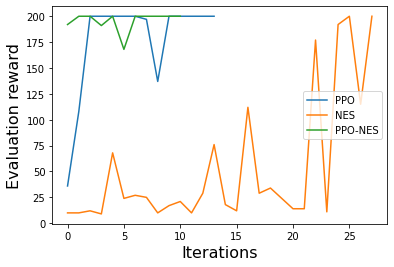

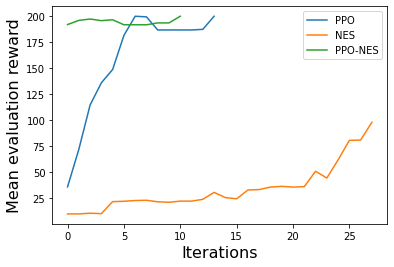

In [ ]:
plt.figure(0)
plt.plot(eval_rewards_PPO, label = 'PPO')
plt.plot(eval_rewards_NES, label = 'NES')
plt.plot(eval_rewards_ppo_es, label = 'PPO-NES')
plt.legend()
plt.ylabel("Evaluation reward",fontsize=16)
plt.xlabel("Iterations",fontsize=16)

plt.figure(1)
plt.plot(eval_rewards_mean_PPO, label = 'PPO')
plt.plot(eval_rewards_mean_NES, label = 'NES')
plt.plot(eval_rewards_mean_ppo_es, label = 'PPO-NES')
plt.legend()
plt.ylabel("Mean evaluation reward",fontsize=16)
plt.xlabel("Iterations",fontsize=16)

# Testing

In [ ]:

terminal = False
rewards = []
rewards.append(0)
env = Monitor(env, './video', force=True, video_callable=lambda episode: True)
s = env.reset()
while not terminal:
  s = torch.tensor(s).type(torch.FloatTensor).to(device)
  dis = policyModel.greedy_action(s)
  action = np.argmax(dis.cpu().data.numpy())
  next_state,r,terminal,_=env.step(action)
  rewards[-1]+=r
  s = next_state
env.close()
show_video('./video')